### 1. COMPREENSÃO DO CONJUNTO DE DADOS

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Criar diretórios de resultados se não existirem
results_dir = '../results'
figures_dir = os.path.join(results_dir, 'figures')
os.makedirs(figures_dir, exist_ok=True)

print(f"📁 Figuras serão salvas em: {figures_dir}")

# Certifique-se de baixar os dados de: https://www.kaggle.com/c/titanic/data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

📁 Figuras serão salvas em: ../results\figures


In [2]:
print("=" * 80)
print("ESTRUTURA DO CONJUNTO DE DADOS")
print("=" * 80)

print("\n📊 Dimensões do dataset de treino:")
print(f"   - Linhas: {df_train.shape[0]}")
print(f"   - Colunas: {df_train.shape[1]}")

print("\n📋 Informações gerais:")
df_train.info()

print("\n🎯 VARIÁVEL ALVO: 'Survived'")
print("   - Tipo: Categórica Binária (0 = Não sobreviveu, 1 = Sobreviveu)")
print(f"   - Distribuição: {df_train['Survived'].value_counts().to_dict()}")


ESTRUTURA DO CONJUNTO DE DADOS

📊 Dimensões do dataset de treino:
   - Linhas: 891
   - Colunas: 12

📋 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

🎯 VARIÁVEL ALVO: 'Survived'
   - Tipo: Categórica Binária (0 = Não sobreviveu, 1 = Sobreviveu)
   - Distribuição: {0: 54

In [3]:
print("\n" + "=" * 80)
print("TIPOS DE DADOS POR ATRIBUTO")
print("=" * 80)

atributos_numericos = df_train.select_dtypes(include=[np.number]).columns.tolist()
atributos_categoricos = df_train.select_dtypes(include=['object']).columns.tolist()

print(f"\n✓ Atributos Numéricos ({len(atributos_numericos)}):")
for col in atributos_numericos:
    print(f"   - {col}: {df_train[col].dtype}")

print(f"\n✓ Atributos Categóricos ({len(atributos_categoricos)}):")
for col in atributos_categoricos:
    print(f"   - {col}: {df_train[col].dtype}")


TIPOS DE DADOS POR ATRIBUTO

✓ Atributos Numéricos (7):
   - PassengerId: int64
   - Survived: int64
   - Pclass: int64
   - Age: float64
   - SibSp: int64
   - Parch: int64
   - Fare: float64

✓ Atributos Categóricos (5):
   - Name: object
   - Sex: object
   - Ticket: object
   - Cabin: object
   - Embarked: object


In [4]:
print("\n" + "=" * 80)
print("ANÁLISE ESTATÍSTICA - ATRIBUTOS NUMÉRICOS")
print("=" * 80)

stats_desc = df_train[atributos_numericos].describe()
print("\n", stats_desc)

print("\n📈 Análise de Distribuição e Outliers:")
for col in atributos_numericos:
    if col == 'PassengerId' or col == 'Survived':
        continue
    
    data = df_train[col].dropna()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    outliers_count = ((data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))).sum()
    skewness = data.skew()
    
    print(f"\n   {col}:")
    print(f"      - Assimetria (Skewness): {skewness:.3f}")
    if abs(skewness) > 1:
        print(f"      - ⚠️ Distribuição ALTAMENTE assimétrica")
    elif abs(skewness) > 0.5:
        print(f"      - ⚠️ Distribuição moderadamente assimétrica")
    else:
        print(f"      - ✓ Distribuição aproximadamente simétrica")
    
    print(f"      - Outliers detectados (IQR): {outliers_count} ({outliers_count/len(data)*100:.1f}%)")


ANÁLISE ESTATÍSTICA - ATRIBUTOS NUMÉRICOS

        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

📈 Análise de Distribuição e Outlier

In [5]:
print("\n" + "=" * 80)
print("ANÁLISE DE ATRIBUTOS CATEGÓRICOS")
print("=" * 80)

for col in atributos_categoricos:
    print(f"\n📊 {col}:")
    value_counts = df_train[col].value_counts()
    unique_count = df_train[col].nunique()
    
    print(f"   - Cardinalidade: {unique_count} valores únicos")
    
    if unique_count > 50:
        print(f"   - ⚠️ ALTA CARDINALIDADE - Requer tratamento especial")
    
    print(f"   - Distribuição de frequências:")
    for value, count in value_counts.head(10).items():
        pct = count / len(df_train) * 100
        print(f"      '{value}': {count} ({pct:.1f}%)")
    
    if unique_count > 10:
        print(f"   - ... (mostrando apenas top 10 de {unique_count} valores)")


ANÁLISE DE ATRIBUTOS CATEGÓRICOS

📊 Name:
   - Cardinalidade: 891 valores únicos
   - ⚠️ ALTA CARDINALIDADE - Requer tratamento especial
   - Distribuição de frequências:
      'Braund, Mr. Owen Harris': 1 (0.1%)
      'Boulos, Mr. Hanna': 1 (0.1%)
      'Frolicher-Stehli, Mr. Maxmillian': 1 (0.1%)
      'Gilinski, Mr. Eliezer': 1 (0.1%)
      'Murdlin, Mr. Joseph': 1 (0.1%)
      'Rintamaki, Mr. Matti': 1 (0.1%)
      'Stephenson, Mrs. Walter Bertram (Martha Eustis)': 1 (0.1%)
      'Elsbury, Mr. William James': 1 (0.1%)
      'Bourke, Miss. Mary': 1 (0.1%)
      'Chapman, Mr. John Henry': 1 (0.1%)
   - ... (mostrando apenas top 10 de 891 valores)

📊 Sex:
   - Cardinalidade: 2 valores únicos
   - Distribuição de frequências:
      'male': 577 (64.8%)
      'female': 314 (35.2%)

📊 Ticket:
   - Cardinalidade: 681 valores únicos
   - ⚠️ ALTA CARDINALIDADE - Requer tratamento especial
   - Distribuição de frequências:
      '347082': 7 (0.8%)
      'CA. 2343': 7 (0.8%)
      '1601': 7 (

In [6]:
print("\n" + "=" * 80)
print("ANÁLISE DE VALORES AUSENTES (MISSING)")
print("=" * 80)

missing_data = pd.DataFrame({
    'Coluna': df_train.columns,
    'Total_Missing': df_train.isnull().sum(),
    'Percentual': (df_train.isnull().sum() / len(df_train) * 100).round(2)
})
missing_data = missing_data[missing_data['Total_Missing'] > 0].sort_values('Total_Missing', ascending=False)

if len(missing_data) > 0:
    print("\n", missing_data.to_string(index=False))
    
    print("\n💡 ESTRATÉGIAS DE IMPUTAÇÃO SUGERIDAS:")
    
    for _, row in missing_data.iterrows():
        col = row['Coluna']
        pct = row['Percentual']
        
        print(f"\n   {col} ({pct}% faltante):")
        
        if col == 'Age':
            print("      - Estratégia 1: Imputar pela MEDIANA (robusto a outliers)")
            print("      - Estratégia 2: Imputar por GRUPO (Pclass + Sex)")
            print("      - Estratégia 3: Modelo preditivo (KNN, Random Forest)")
        
        elif col == 'Cabin':
            print("      - Estratégia 1: Criar categoria 'Desconhecido'")
            print("      - Estratégia 2: Extrair apenas o DECK (primeira letra)")
            print("      - Estratégia 3: Feature binária 'Tem_Cabine' (sim/não)")
        
        elif col == 'Embarked':
            print("      - Estratégia: Imputar pela MODA (valor mais frequente)")
        
        elif df_train[col].dtype in [np.float64, np.int64]:
            print("      - Estratégia 1: Imputar pela MEDIANA")
            print("      - Estratégia 2: Imputar pela MÉDIA")
        else:
            print("      - Estratégia: Imputar pela MODA ou criar categoria 'Missing'")
else:
    print("\n✓ Não há valores ausentes no dataset!")


ANÁLISE DE VALORES AUSENTES (MISSING)

   Coluna  Total_Missing  Percentual
   Cabin            687       77.10
     Age            177       19.87
Embarked              2        0.22

💡 ESTRATÉGIAS DE IMPUTAÇÃO SUGERIDAS:

   Cabin (77.1% faltante):
      - Estratégia 1: Criar categoria 'Desconhecido'
      - Estratégia 2: Extrair apenas o DECK (primeira letra)
      - Estratégia 3: Feature binária 'Tem_Cabine' (sim/não)

   Age (19.87% faltante):
      - Estratégia 1: Imputar pela MEDIANA (robusto a outliers)
      - Estratégia 2: Imputar por GRUPO (Pclass + Sex)
      - Estratégia 3: Modelo preditivo (KNN, Random Forest)

   Embarked (0.22% faltante):
      - Estratégia: Imputar pela MODA (valor mais frequente)


### 2. IMPORTÂNCIA E RELACIONAMENTOS ENTRE ATRIBUTOS

In [7]:
print("\n" + "=" * 80)
print("MATRIZ DE CORRELAÇÃO - ATRIBUTOS NUMÉRICOS")
print("=" * 80)

# Remove PassengerId pois não é informativo
numeric_cols = [col for col in atributos_numericos if col != 'PassengerId']
correlation_matrix = df_train[numeric_cols].corr()

print("\n", correlation_matrix.round(3))

print("\n🔍 CORRELAÇÕES FORTES COM A VARIÁVEL ALVO (Survived):")
target_corr = correlation_matrix['Survived'].drop('Survived').sort_values(ascending=False)
for col, corr_val in target_corr.items():
    if abs(corr_val) > 0.1:
        direction = "POSITIVA" if corr_val > 0 else "NEGATIVA"
        strength = "FORTE" if abs(corr_val) > 0.3 else "MODERADA"
        print(f"   - {col}: {corr_val:.3f} ({direction}, {strength})")

print("\n🔗 CORRELAÇÕES ENTRE PREDITORES:")
for i, col1 in enumerate(numeric_cols[:-1]):
    for col2 in numeric_cols[i+1:]:
        if col1 != 'Survived' and col2 != 'Survived':
            corr_val = correlation_matrix.loc[col1, col2]
            if abs(corr_val) > 0.5:
                print(f"   - {col1} ↔ {col2}: {corr_val:.3f} ⚠️ MULTICOLINEARIDADE!")


MATRIZ DE CORRELAÇÃO - ATRIBUTOS NUMÉRICOS

           Survived  Pclass    Age  SibSp  Parch   Fare
Survived     1.000  -0.338 -0.077 -0.035  0.082  0.257
Pclass      -0.338   1.000 -0.369  0.083  0.018 -0.549
Age         -0.077  -0.369  1.000 -0.308 -0.189  0.096
SibSp       -0.035   0.083 -0.308  1.000  0.415  0.160
Parch        0.082   0.018 -0.189  0.415  1.000  0.216
Fare         0.257  -0.549  0.096  0.160  0.216  1.000

🔍 CORRELAÇÕES FORTES COM A VARIÁVEL ALVO (Survived):
   - Fare: 0.257 (POSITIVA, MODERADA)
   - Pclass: -0.338 (NEGATIVA, FORTE)

🔗 CORRELAÇÕES ENTRE PREDITORES:
   - Pclass ↔ Fare: -0.549 ⚠️ MULTICOLINEARIDADE!


In [8]:
print("\n" + "=" * 80)
print("TESTE QUI-QUADRADO - ATRIBUTOS CATEGÓRICOS vs SURVIVED")
print("=" * 80)

print("\nHipótese Nula (H0): Não há relação entre o atributo e a sobrevivência")
print("Hipótese Alternativa (H1): Há relação significativa entre o atributo e a sobrevivência")
print("Nível de significância: α = 0.05\n")

chi2_results = []

for col in atributos_categoricos:
    # Remove valores nulos para o teste
    temp_df = df_train[[col, 'Survived']].dropna()
    
    # Cria tabela de contingência
    contingency_table = pd.crosstab(temp_df[col], temp_df['Survived'])
    
    # Teste qui-quadrado
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Atributo': col,
        'Chi2': chi2,
        'p-valor': p_value,
        'Significativo': 'SIM' if p_value < 0.05 else 'NÃO'
    })
    
    print(f"📊 {col}:")
    print(f"   - Estatística χ²: {chi2:.4f}")
    print(f"   - p-valor: {p_value:.4e}")
    
    if p_value < 0.001:
        print(f"   - ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)")
    elif p_value < 0.01:
        print(f"   - ✅ MUITO SIGNIFICATIVO (p < 0.01)")
    elif p_value < 0.05:
        print(f"   - ✅ SIGNIFICATIVO (p < 0.05)")
    else:
        print(f"   - ❌ NÃO SIGNIFICATIVO (p >= 0.05)")
    
    print(f"   - Conclusão: {'Rejeita H0 - Há relação com sobrevivência' if p_value < 0.05 else 'Não rejeita H0 - Sem evidência de relação'}")
    print()

chi2_df = pd.DataFrame(chi2_results).sort_values('p-valor')
print("\n📈 Resumo ordenado por significância:")
print(chi2_df.to_string(index=False))


TESTE QUI-QUADRADO - ATRIBUTOS CATEGÓRICOS vs SURVIVED

Hipótese Nula (H0): Não há relação entre o atributo e a sobrevivência
Hipótese Alternativa (H1): Há relação significativa entre o atributo e a sobrevivência
Nível de significância: α = 0.05

📊 Name:
   - Estatística χ²: 891.0000
   - p-valor: 4.8425e-01
   - ❌ NÃO SIGNIFICATIVO (p >= 0.05)
   - Conclusão: Não rejeita H0 - Sem evidência de relação

📊 Sex:
   - Estatística χ²: 260.7170
   - p-valor: 1.1974e-58
   - ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)
   - Conclusão: Rejeita H0 - Há relação com sobrevivência

📊 Ticket:
   - Estatística χ²: 766.5697
   - p-valor: 1.1527e-02
   - ✅ SIGNIFICATIVO (p < 0.05)
   - Conclusão: Rejeita H0 - Há relação com sobrevivência

📊 Cabin:
   - Estatística χ²: 161.2500
   - p-valor: 1.8357e-01
   - ❌ NÃO SIGNIFICATIVO (p >= 0.05)
   - Conclusão: Não rejeita H0 - Sem evidência de relação

📊 Embarked:
   - Estatística χ²: 26.4891
   - p-valor: 1.7699e-06
   - ✅ ALTAMENTE SIGNIFICATIVO (p < 0.001)
   -

In [9]:
print("\n" + "=" * 80)
print("OPORTUNIDADES DE ENGENHARIA DE ATRIBUTOS")
print("=" * 80)

print("\n💡 SUGESTÕES BASEADAS NA ANÁLISE:")

print("\n1. FAMÍLIA E GRUPO:")
print("   - FamilySize = SibSp + Parch + 1")
print("   - IsAlone = 1 se FamilySize == 1, senão 0")
print("   - Justificativa: Famílias podem ter comportamento diferente na evacuação")

print("\n2. TÍTULO DO NOME:")
print("   - Extrair título de 'Name' (Mr, Mrs, Miss, Master, etc.)")
print("   - Agrupar títulos raros em 'Other'")
print("   - Justificativa: Título indica status social e idade aproximada")

print("\n3. DECK DA CABINE:")
print("   - Extrair primeira letra de 'Cabin' (A-G)")
print("   - Deck pode indicar localização no navio (proximidade de saídas)")
print("   - Criar flag 'HasCabin' (0/1)")

print("\n4. FAIXA ETÁRIA:")
print("   - Criar bins: Criança (<12), Adolescente (12-18), Adulto (18-60), Idoso (>60)")
print("   - Justificativa: Diferentes faixas etárias podem ter taxas de sobrevivência distintas")

print("\n5. TARIFA POR PESSOA:")
print("   - FarePerPerson = Fare / FamilySize")
print("   - Justificativa: Normaliza tarifa pelo tamanho do grupo")

print("\n6. COMBINAÇÕES DE ATRIBUTOS:")
print("   - Pclass_Sex = combinação de classe e sexo")
print("   - Age_Class = interação entre idade e classe")
print("   - Justificativa: Capturam efeitos de interação complexos")


OPORTUNIDADES DE ENGENHARIA DE ATRIBUTOS

💡 SUGESTÕES BASEADAS NA ANÁLISE:

1. FAMÍLIA E GRUPO:
   - FamilySize = SibSp + Parch + 1
   - IsAlone = 1 se FamilySize == 1, senão 0
   - Justificativa: Famílias podem ter comportamento diferente na evacuação

2. TÍTULO DO NOME:
   - Extrair título de 'Name' (Mr, Mrs, Miss, Master, etc.)
   - Agrupar títulos raros em 'Other'
   - Justificativa: Título indica status social e idade aproximada

3. DECK DA CABINE:
   - Extrair primeira letra de 'Cabin' (A-G)
   - Deck pode indicar localização no navio (proximidade de saídas)
   - Criar flag 'HasCabin' (0/1)

4. FAIXA ETÁRIA:
   - Criar bins: Criança (<12), Adolescente (12-18), Adulto (18-60), Idoso (>60)
   - Justificativa: Diferentes faixas etárias podem ter taxas de sobrevivência distintas

5. TARIFA POR PESSOA:
   - FarePerPerson = Fare / FamilySize
   - Justificativa: Normaliza tarifa pelo tamanho do grupo

6. COMBINAÇÕES DE ATRIBUTOS:
   - Pclass_Sex = combinação de classe e sexo
   - Age_C

In [10]:
print("\n" + "=" * 80)
print("ANÁLISE DE MULTICOLINEARIDADE")
print("=" * 80)

print("\n🔍 Pares de atributos com alta correlação (|r| > 0.7):")
high_corr_found = False

for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        if col1 != col2:
            corr_val = correlation_matrix.loc[col1, col2]
            if abs(corr_val) > 0.7:
                high_corr_found = True
                print(f"   - {col1} ↔ {col2}: r = {corr_val:.3f}")
                print(f"     ⚠️ Considerar remover um dos atributos ou criar PCA")

if not high_corr_found:
    print("   ✓ Não foram detectados pares com multicolinearidade severa")

print("\n💡 IMPACTO EM ÁRVORES DE DECISÃO:")
print("   - Árvores de Decisão são ROBUSTAS à multicolinearidade")
print("   - Algoritmo seleciona automaticamente o melhor atributo em cada split")
print("   - Problema maior para modelos lineares (Regressão Logística, etc.)")


ANÁLISE DE MULTICOLINEARIDADE

🔍 Pares de atributos com alta correlação (|r| > 0.7):
   ✓ Não foram detectados pares com multicolinearidade severa

💡 IMPACTO EM ÁRVORES DE DECISÃO:
   - Árvores de Decisão são ROBUSTAS à multicolinearidade
   - Algoritmo seleciona automaticamente o melhor atributo em cada split
   - Problema maior para modelos lineares (Regressão Logística, etc.)


### 3. VISUALIZAÇÃO DE DADOS


GERANDO VISUALIZAÇÕES...
✓ Histogramas salvos em: results/figures/01_histogramas.png


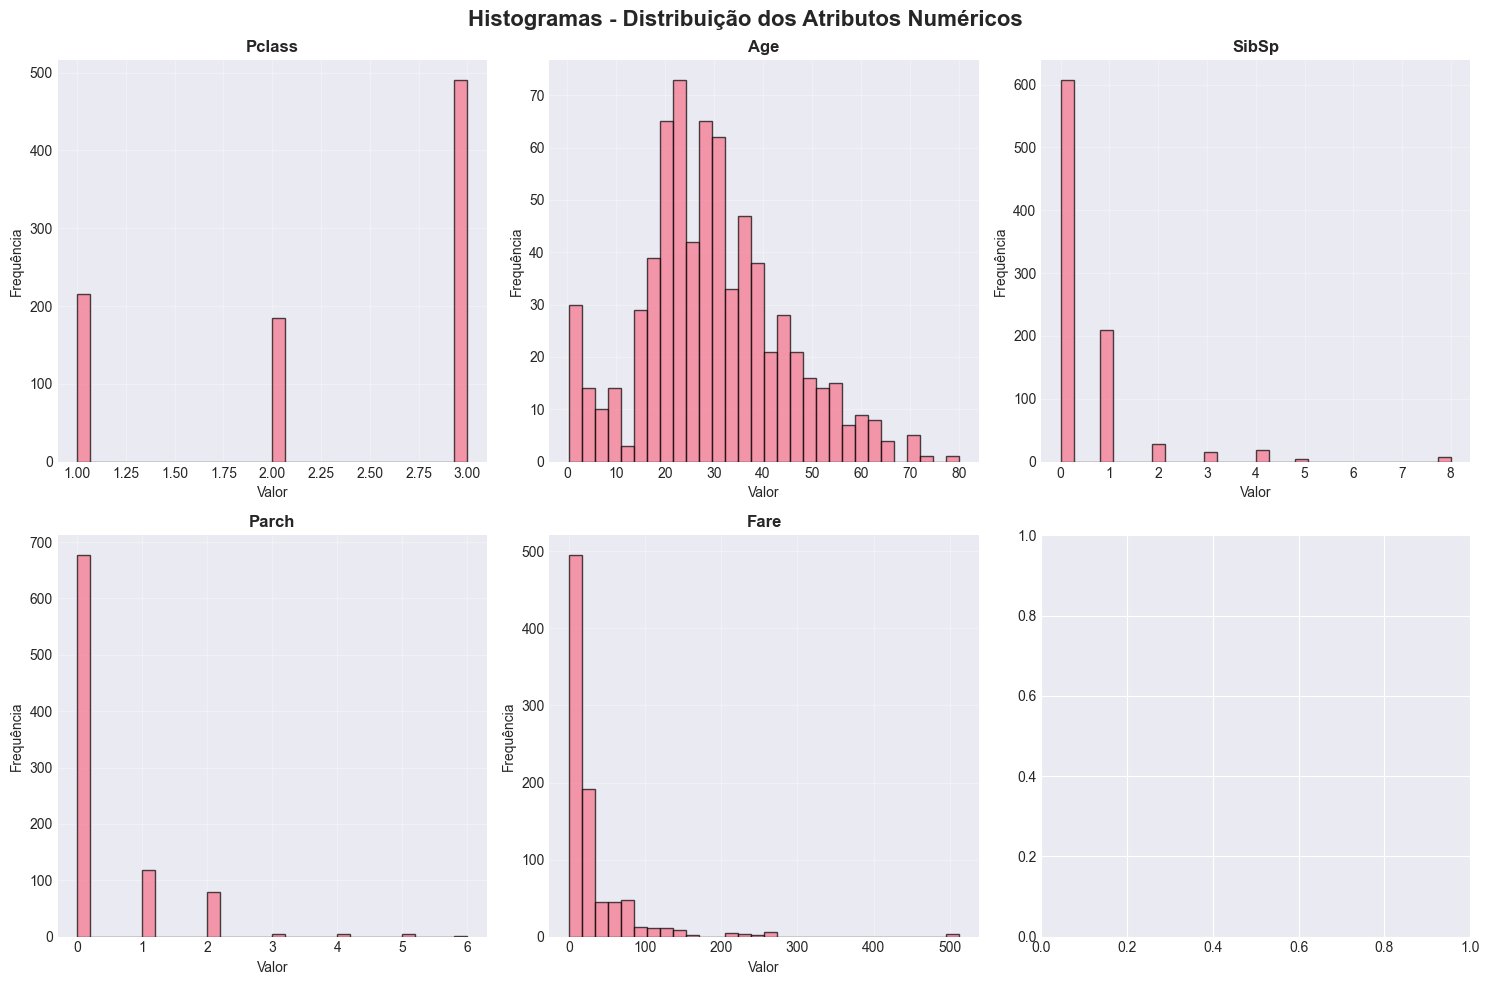

In [11]:
print("\n" + "=" * 80)
print("GERANDO VISUALIZAÇÕES...")
print("=" * 80)

# Histogramas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Histogramas - Distribuição dos Atributos Numéricos', fontsize=16, fontweight='bold')

numeric_plot_cols = [col for col in numeric_cols if col != 'Survived']

for idx, col in enumerate(numeric_plot_cols):
    row = idx // 3
    col_idx = idx % 3
    
    ax = axes[row, col_idx]
    df_train[col].dropna().hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_histogramas.png'), dpi=300, bbox_inches='tight')
print("✓ Histogramas salvos em: results/figures/01_histogramas.png")

✓ Box Plots salvos em: results/figures/02_boxplots.png


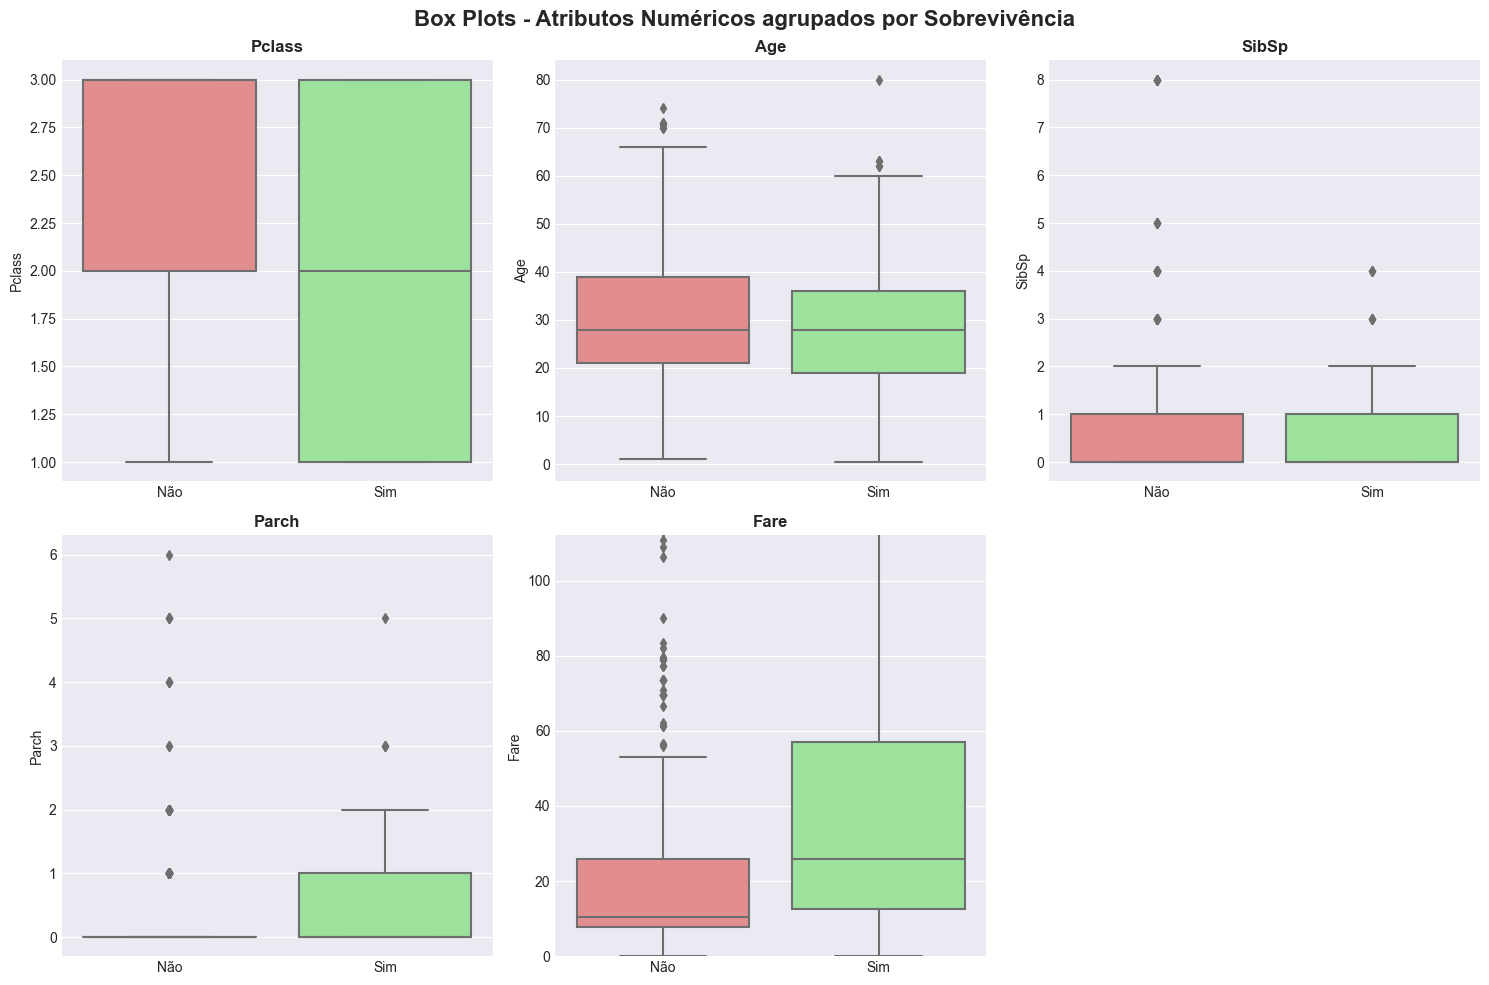

In [12]:
# Escolhe colunas numéricas úteis para boxplots (exclui PassengerId e Survived)
numeric_plot_cols = [c for c in atributos_numericos if c not in ('PassengerId','Survived')]

# Se quiser pular Pclass (discreta) coloque: numeric_plot_cols = [c for c in numeric_plot_cols if c!='Pclass']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Box Plots - Atributos Numéricos agrupados por Sobrevivência', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, col in enumerate(numeric_plot_cols[:6]):  # limita a 6 subplots
    ax = axes[idx]

    # Usa seaborn, agrupa por 'Survived'
    sns.boxplot(x='Survived', y=col, data=df_train, ax=ax, palette=['lightcoral','lightgreen'])

    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xlabel('')  # remove label padrão
    ax.set_xticklabels(['Não', 'Sim'])
    ax.set_ylabel(col)

    # Tratamento especial para colunas com outliers extremos (ex.: Fare)
    if col == 'Fare':
        # limitar y pelo percentil 95 para visualizar melhor a caixa
        upper = df_train['Fare'].quantile(0.95)
        ax.set_ylim(bottom=0, top=upper)

# Desliga eixos extras caso haja menos de 6 colunas
for j in range(len(numeric_plot_cols[:6]), len(axes)):
    axes[j].axis('off')

fig.subplots_adjust(top=0.92)  # evita sobreposição do suptitle
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '02_boxplots.png'), dpi=300, bbox_inches='tight')
print("✓ Box Plots salvos em: results/figures/02_boxplots.png")

✓ Gráfico de barras salvo: results/figures/03_barras_Sex.png
✓ Gráfico de barras salvo: results/figures/03_barras_Pclass.png
✓ Gráfico de barras salvo: results/figures/03_barras_Embarked.png


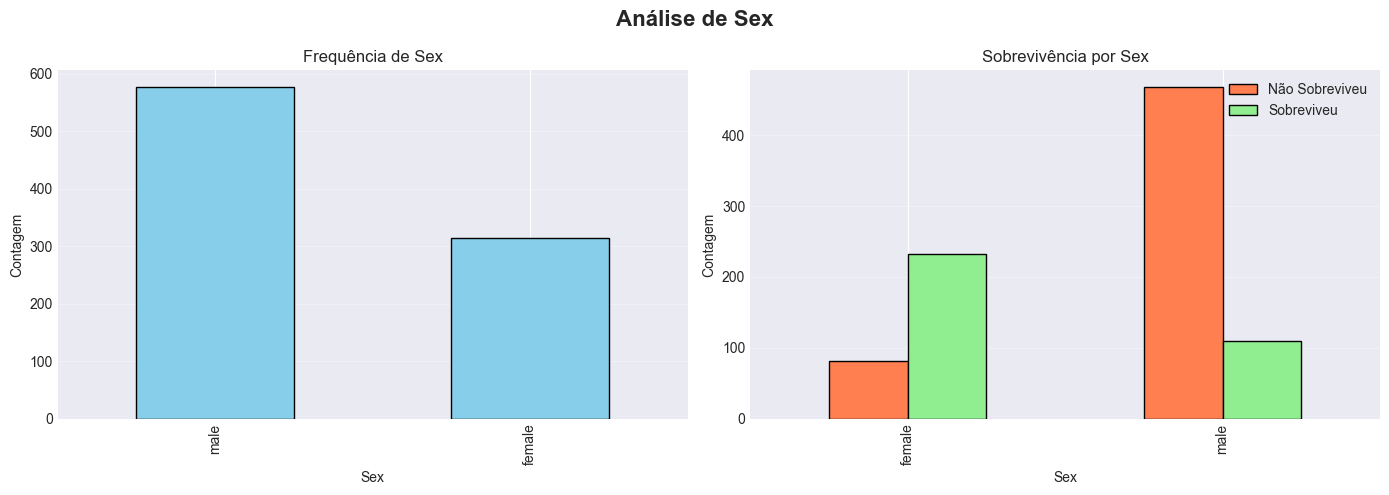

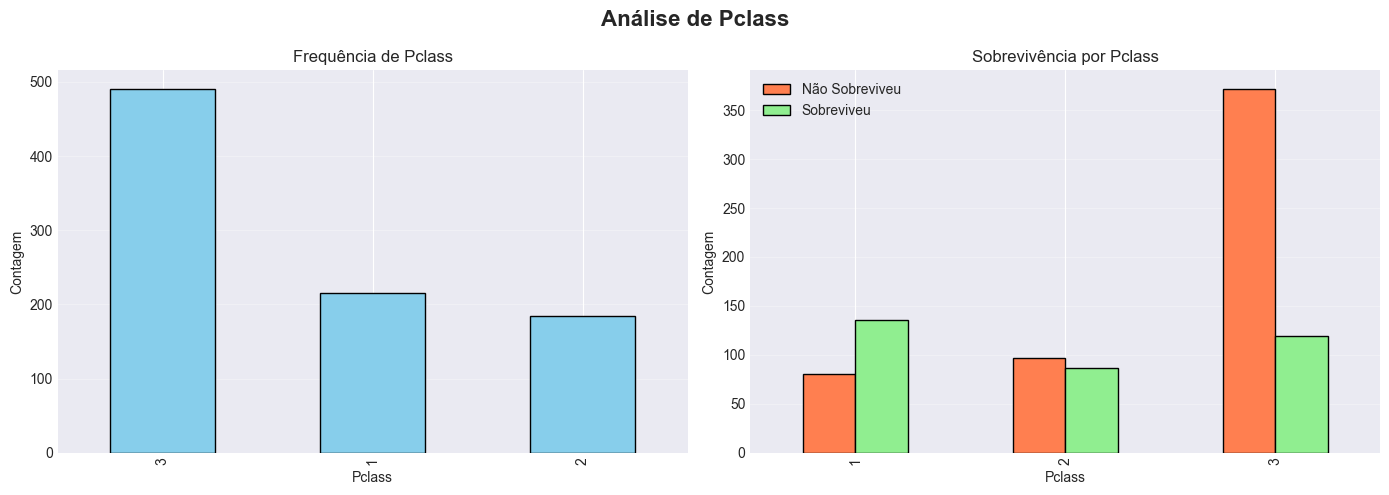

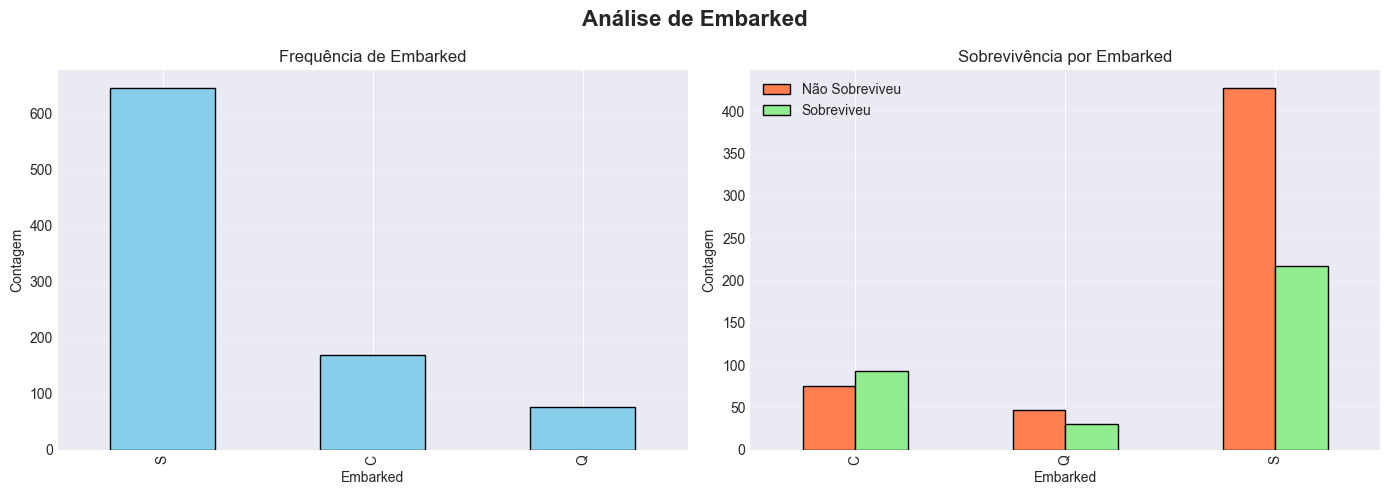

In [13]:
for col in ['Sex', 'Pclass', 'Embarked']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Análise de {col}', fontsize=16, fontweight='bold')
    
    # Frequência geral
    df_train[col].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(f'Frequência de {col}')
    axes[0].set_ylabel('Contagem')
    axes[0].set_xlabel(col)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Sobrevivência por categoria
    survival_by_cat = df_train.groupby([col, 'Survived']).size().unstack()
    survival_by_cat.plot(kind='bar', ax=axes[1], color=['coral', 'lightgreen'], edgecolor='black')
    axes[1].set_title(f'Sobrevivência por {col}')
    axes[1].set_ylabel('Contagem')
    axes[1].set_xlabel(col)
    axes[1].legend(['Não Sobreviveu', 'Sobreviveu'])
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, f'03_barras_{col}.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Gráfico de barras salvo: results/figures/03_barras_{col}.png")

✓ Heatmap salvo em: results/figures/04_heatmap_correlacao.png


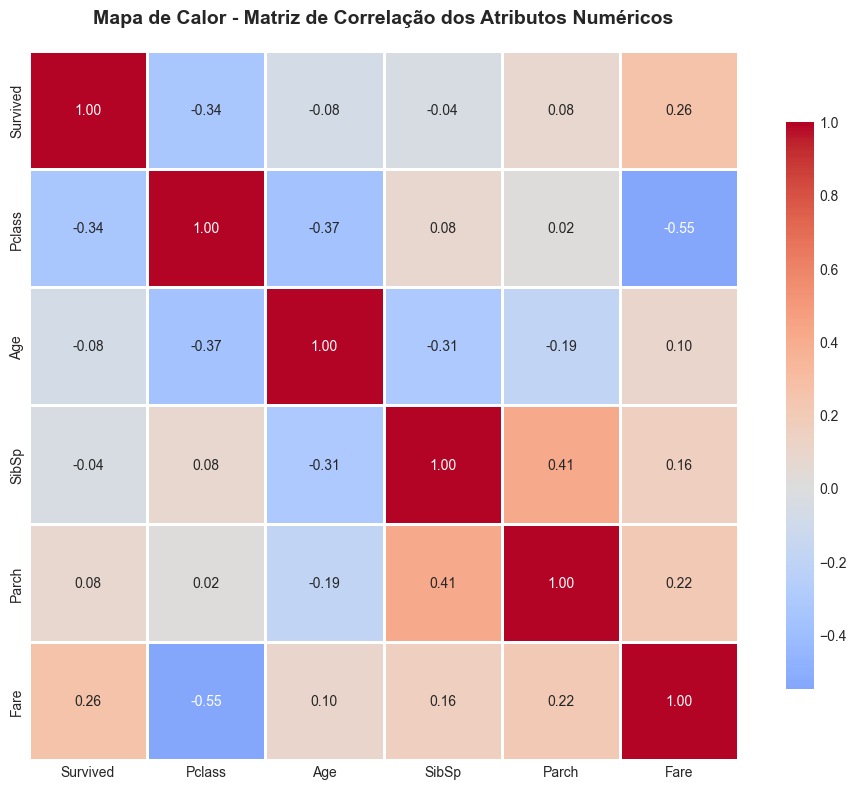

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Mapa de Calor - Matriz de Correlação dos Atributos Numéricos', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_heatmap_correlacao.png'), dpi=300, bbox_inches='tight')
print("✓ Heatmap salvo em: results/figures/04_heatmap_correlacao.png")

### 4. EXPLORAÇÃO ESPECÍFICA PARA ÁRVORE DE DECISÃO

In [15]:
print("\n" + "=" * 80)
print("ANÁLISE ESPECÍFICA PARA ÁRVORE DE DECISÃO")
print("=" * 80)

print("\n🌳 ATRIBUTOS CANDIDATOS PARA SPLITS INICIAIS (ROOT NODE):")
print("\nBaseado em correlação, qui-quadrado e importância teórica:\n")

# Ranking de importância
importance_ranking = []

# Adiciona atributos numéricos
for col in numeric_cols:
    if col != 'Survived':
        corr_val = abs(correlation_matrix.loc['Survived', col])
        importance_ranking.append({
            'Atributo': col,
            'Tipo': 'Numérico',
            'Métrica': f'|Correlação| = {corr_val:.3f}',
            'Score': corr_val
        })

# Adiciona atributos categóricos
for result in chi2_results:
    # Normaliza chi2 para comparação
    normalized_score = min(result['p-valor'] * -10, 1)  # Quanto menor p-valor, maior score
    importance_ranking.append({
        'Atributo': result['Atributo'],
        'Tipo': 'Categórico',
        'Métrica': f"p-valor = {result['p-valor']:.4f}",
        'Score': 1 - result['p-valor'] if result['p-valor'] < 0.05 else 0
    })

# Ordena por score
importance_df = pd.DataFrame(importance_ranking).sort_values('Score', ascending=False)

print("📊 RANKING DE PREDITORES:")
for idx, row in importance_df.head(8).iterrows():
    print(f"\n   {int(idx)+1}. {row['Atributo']} ({row['Tipo']})")
    print(f"      - {row['Métrica']}")
    print(f"      - Score: {row['Score']:.3f}")


ANÁLISE ESPECÍFICA PARA ÁRVORE DE DECISÃO

🌳 ATRIBUTOS CANDIDATOS PARA SPLITS INICIAIS (ROOT NODE):

Baseado em correlação, qui-quadrado e importância teórica:

📊 RANKING DE PREDITORES:

   7. Sex (Categórico)
      - p-valor = 0.0000
      - Score: 1.000

   10. Embarked (Categórico)
      - p-valor = 0.0000
      - Score: 1.000

   8. Ticket (Categórico)
      - p-valor = 0.0115
      - Score: 0.988

   1. Pclass (Numérico)
      - |Correlação| = 0.338
      - Score: 0.338

   5. Fare (Numérico)
      - |Correlação| = 0.257
      - Score: 0.257

   4. Parch (Numérico)
      - |Correlação| = 0.082
      - Score: 0.082

   2. Age (Numérico)
      - |Correlação| = 0.077
      - Score: 0.077

   3. SibSp (Numérico)
      - |Correlação| = 0.035
      - Score: 0.035


In [16]:
print("\n" + "=" * 80)
print("PROBLEMAS POTENCIAIS PARA ÁRVORES DE DECISÃO")
print("=" * 80)

print("\n⚠️ OVERFITTING (Sobre-ajustamento):")
print("   Causas identificadas:")
print(f"   - Dataset pequeno: {len(df_train)} exemplos")
print(f"   - Alta cardinalidade: 'Cabin' tem {df_train['Cabin'].nunique()} valores únicos")
print(f"   - Atributos com outliers: Age, Fare")
print("   \n   Soluções:")
print("   - Usar PRÉ-PRUNING (max_depth, min_samples_split, min_samples_leaf)")
print("   - Usar PÓS-PRUNING (cost complexity pruning)")
print("   - Cross-validation para ajuste de hiperparâmetros")
print("   - Limitar max_features para reduzir complexidade")

print("\n⚠️ UNDERFITTING (Sub-ajustamento):")
print("   Causas potenciais:")
print("   - Árvore muito rasa (max_depth muito baixo)")
print("   - min_samples_split muito alto")
print("   - Remoção excessiva de atributos informativos")
print("   \n   Soluções:")
print("   - Aumentar max_depth gradualmente")
print("   - Reduzir min_samples_split")
print("   - Incluir features engineered")

print("\n⚠️ VALORES AUSENTES:")
print(f"   - Age: {df_train['Age'].isnull().sum()} valores faltantes ({df_train['Age'].isnull().sum()/len(df_train)*100:.1f}%)")
print(f"   - Cabin: {df_train['Cabin'].isnull().sum()} valores faltantes ({df_train['Cabin'].isnull().sum()/len(df_train)*100:.1f}%)")
print("   - Scikit-learn não aceita valores NaN nativamente")
print("   - Necessário imputar ANTES de treinar")


PROBLEMAS POTENCIAIS PARA ÁRVORES DE DECISÃO

⚠️ OVERFITTING (Sobre-ajustamento):
   Causas identificadas:
   - Dataset pequeno: 891 exemplos
   - Alta cardinalidade: 'Cabin' tem 147 valores únicos
   - Atributos com outliers: Age, Fare
   
   Soluções:
   - Usar PRÉ-PRUNING (max_depth, min_samples_split, min_samples_leaf)
   - Usar PÓS-PRUNING (cost complexity pruning)
   - Cross-validation para ajuste de hiperparâmetros
   - Limitar max_features para reduzir complexidade

⚠️ UNDERFITTING (Sub-ajustamento):
   Causas potenciais:
   - Árvore muito rasa (max_depth muito baixo)
   - min_samples_split muito alto
   - Remoção excessiva de atributos informativos
   
   Soluções:
   - Aumentar max_depth gradualmente
   - Reduzir min_samples_split
   - Incluir features engineered

⚠️ VALORES AUSENTES:
   - Age: 177 valores faltantes (19.9%)
   - Cabin: 687 valores faltantes (77.1%)
   - Scikit-learn não aceita valores NaN nativamente
   - Necessário imputar ANTES de treinar


In [17]:
print("\n" + "=" * 80)
print("ANÁLISE DE BALANCEAMENTO DE CLASSES")
print("=" * 80)

class_distribution = df_train['Survived'].value_counts()
class_ratio = class_distribution[0] / class_distribution[1]

print(f"\n📊 Distribuição da Variável Alvo:")
print(f"   - Não Sobreviveu (0): {class_distribution[0]} ({class_distribution[0]/len(df_train)*100:.1f}%)")
print(f"   - Sobreviveu (1): {class_distribution[1]} ({class_distribution[1]/len(df_train)*100:.1f}%)")
print(f"   - Razão: {class_ratio:.2f}:1")

if class_ratio > 1.5 or class_ratio < 0.67:
    print("\n   ⚠️ CLASSES MODERADAMENTE DESBALANCEADAS")
    
    print("\n💡 ESTRATÉGIAS PARA LIDAR COM DESBALANCEAMENTO:")
    print("\n   1. AJUSTE DE PESOS DAS CLASSES:")
    print("      - DecisionTreeClassifier(class_weight='balanced')")
    print("      - Penaliza mais erros na classe minoritária")
    
    print("\n   2. REAMOSTRAGEM:")
    print("      - Oversampling da classe minoritária (SMOTE)")
    print("      - Undersampling da classe majoritária")
    print("      - Combinação de ambos")
    
    print("\n   3. MÉTRICAS APROPRIADAS:")
    print("      - NÃO usar apenas Acurácia (pode ser enganosa)")
    print("      - Usar F1-Score, Precision, Recall")
    print("      - Analisar Matriz de Confusão")
    print("      - Considerar AUC-ROC")
    
    print("\n   4. THRESHOLD ADJUSTMENT:")
    print("      - Ajustar threshold de decisão (padrão 0.5)")
    print("      - Otimizar para F1 ou outra métrica de interesse")
else:
    print("\n   ✓ Classes razoavelmente balanceadas")
    print("   - Estratégias padrão devem funcionar bem")


ANÁLISE DE BALANCEAMENTO DE CLASSES

📊 Distribuição da Variável Alvo:
   - Não Sobreviveu (0): 549 (61.6%)
   - Sobreviveu (1): 342 (38.4%)
   - Razão: 1.61:1

   ⚠️ CLASSES MODERADAMENTE DESBALANCEADAS

💡 ESTRATÉGIAS PARA LIDAR COM DESBALANCEAMENTO:

   1. AJUSTE DE PESOS DAS CLASSES:
      - DecisionTreeClassifier(class_weight='balanced')
      - Penaliza mais erros na classe minoritária

   2. REAMOSTRAGEM:
      - Oversampling da classe minoritária (SMOTE)
      - Undersampling da classe majoritária
      - Combinação de ambos

   3. MÉTRICAS APROPRIADAS:
      - NÃO usar apenas Acurácia (pode ser enganosa)
      - Usar F1-Score, Precision, Recall
      - Analisar Matriz de Confusão
      - Considerar AUC-ROC

   4. THRESHOLD ADJUSTMENT:
      - Ajustar threshold de decisão (padrão 0.5)
      - Otimizar para F1 ou outra métrica de interesse


In [18]:
print("\n" + "=" * 80)
print("MÉTRICAS DE AVALIAÇÃO RECOMENDADAS")
print("=" * 80)

print("\n🎯 PARA ESTE PROBLEMA (Classificação Binária):")

print("\n1. ACURÁCIA (Accuracy)")
print("   - Fórmula: (VP + VN) / Total")
print("   - Quando usar: Classes balanceadas")
print("   - ⚠️ Cuidado: Pode ser enganosa com desbalanceamento")

print("\n2. PRECISION (Precisão)")
print("   - Fórmula: VP / (VP + FP)")
print("   - Pergunta: 'Dos que previ como sobreviventes, quantos realmente sobreviveram?'")
print("   - Importante quando: Custo de Falso Positivo é alto")

print("\n3. RECALL (Sensibilidade/Revocação)")
print("   - Fórmula: VP / (VP + FN)")
print("   - Pergunta: 'Dos que sobreviveram, quantos consegui identificar?'")
print("   - Importante quando: Custo de Falso Negativo é alto")

print("\n4. F1-SCORE")
print("   - Fórmula: 2 * (Precision * Recall) / (Precision + Recall)")
print("   - Média harmônica entre Precision e Recall")
print("   - ✅ RECOMENDADO para classes desbalanceadas")

print("\n5. MATRIZ DE CONFUSÃO")
print("   - Visualiza VP, VN, FP, FN")
print("   - ✅ ESSENCIAL para entender erros do modelo")

print("\n6. AUC-ROC (Area Under Curve)")
print("   - Mede capacidade de discriminação em diferentes thresholds")
print("   - ✅ ROBUSTO ao desbalanceamento")
print("   - Varia de 0.5 (aleatório) a 1.0 (perfeito)")

print("\n7. VALIDAÇÃO CRUZADA")
print("   - ✅ ESSENCIAL: Usar 5-fold ou 10-fold cross-validation")
print("   - Evita viés de uma única divisão treino/teste")
print("   - Scikit-learn: cross_val_score()")

print("\n💡 RECOMENDAÇÃO FINAL:")
print("   Métricas principais: F1-Score + AUC-ROC")
print("   Análise obrigatória: Matriz de Confusão")
print("   Validação: Cross-validation 5-fold")


MÉTRICAS DE AVALIAÇÃO RECOMENDADAS

🎯 PARA ESTE PROBLEMA (Classificação Binária):

1. ACURÁCIA (Accuracy)
   - Fórmula: (VP + VN) / Total
   - Quando usar: Classes balanceadas
   - ⚠️ Cuidado: Pode ser enganosa com desbalanceamento

2. PRECISION (Precisão)
   - Fórmula: VP / (VP + FP)
   - Pergunta: 'Dos que previ como sobreviventes, quantos realmente sobreviveram?'
   - Importante quando: Custo de Falso Positivo é alto

3. RECALL (Sensibilidade/Revocação)
   - Fórmula: VP / (VP + FN)
   - Pergunta: 'Dos que sobreviveram, quantos consegui identificar?'
   - Importante quando: Custo de Falso Negativo é alto

4. F1-SCORE
   - Fórmula: 2 * (Precision * Recall) / (Precision + Recall)
   - Média harmônica entre Precision e Recall
   - ✅ RECOMENDADO para classes desbalanceadas

5. MATRIZ DE CONFUSÃO
   - Visualiza VP, VN, FP, FN
   - ✅ ESSENCIAL para entender erros do modelo

6. AUC-ROC (Area Under Curve)
   - Mede capacidade de discriminação em diferentes thresholds
   - ✅ ROBUSTO ao desba

### CONCLUSÕES E PRÓXIMOS PASSOS

In [19]:
print("\n" + "=" * 80)
print("RESUMO EXECUTIVO DA ANÁLISE EXPLORATÓRIA")
print("=" * 80)

print("\n📊 DATASET:")
print(f"   - {df_train.shape[0]} observações, {df_train.shape[1]} atributos")
print(f"   - Target: Survived (62% não sobreviveu, 38% sobreviveu)")
print(f"   - Classes moderadamente desbalanceadas")

print("\n🎯 PREDITORES MAIS IMPORTANTES:")
print("   1. Sex (p < 0.001) - Mulheres tiveram maior taxa de sobrevivência")
print("   2. Pclass (p < 0.001) - Classe social impactou chances")
print("   3. Fare (r = 0.26) - Correlação positiva com sobrevivência")
print("   4. Age (após imputação) - Crianças tiveram prioridade")

print("\n⚠️ PROBLEMAS IDENTIFICADOS:")
print("   - 19.9% de valores ausentes em Age")
print("   - 77.1% de valores ausentes em Cabin")
print("   - Alta cardinalidade em Name, Ticket, Cabin")
print("   - Distribuição assimétrica em Fare")
print("   - Outliers em Age e Fare")

print("\n💡 FEATURES SUGERIDAS (ENGINEERING):")
print("   - FamilySize = SibSp + Parch + 1")
print("   - IsAlone = (FamilySize == 1)")
print("   - Title (extraído de Name)")
print("   - Deck (extraído de Cabin)")
print("   - AgeGroup (faixas etárias)")
print("   - FarePerPerson = Fare / FamilySize")

print("\n🌳 RECOMENDAÇÕES PARA ÁRVORE DE DECISÃO:")
print("   Hiperparâmetros iniciais:")
print("   - max_depth: 5-7 (evitar overfitting)")
print("   - min_samples_split: 20")
print("   - min_samples_leaf: 10")
print("   - class_weight: 'balanced'")
print("   - criterion: testar 'gini' e 'entropy'")

print("\n📈 MÉTRICAS DE AVALIAÇÃO:")
print("   - Principal: F1-Score")
print("   - Secundária: AUC-ROC")
print("   - Obrigatório: Matriz de Confusão")
print("   - Validação: 5-fold cross-validation")

print("\n✅ PRÓXIMOS PASSOS:")
print("   1. Imputar valores ausentes conforme estratégias sugeridas")
print("   2. Criar features engineered")
print("   3. Codificar variáveis categóricas (One-Hot ou Label Encoding)")
print("   4. Treinar DecisionTreeClassifier")
print("   5. Otimizar hiperparâmetros (Grid Search ou Random Search)")
print("   6. Avaliar com métricas recomendadas")
print("   7. Comparar com Random Forest")
print("   8. Visualizar árvore resultante")
print("   9. Analisar importância das features")
print("   10. Fazer predições no conjunto de teste")

print("\n" + "=" * 80)
print("✓ ANÁLISE EXPLORATÓRIA CONCLUÍDA COM SUCESSO!")
print("=" * 80)

print("\n📁 Arquivos gerados:")
num_figures = len([f for f in os.listdir(figures_dir) if f.endswith('.png')])
print(f"   - Figuras: {num_figures} visualizações salvas")
print(f"   - Localização: {figures_dir}")

print("\n📝 Este notebook respondeu às 4 seções de perguntas:")
print("   ✓ 1. Compreensão do Conjunto de Dados")
print("   ✓ 2. Importância e Relacionamentos entre Atributos")
print("   ✓ 3. Visualização de Dados")
print("   ✓ 4. Exploração Específica para Árvore de Decisão")

print("\n🚀 Pronto para as próximas etapas:")
print("   → Notebook 02: Pré-processamento")
print("   → Notebook 03: Modelagem e Otimização")


RESUMO EXECUTIVO DA ANÁLISE EXPLORATÓRIA

📊 DATASET:
   - 891 observações, 12 atributos
   - Target: Survived (62% não sobreviveu, 38% sobreviveu)
   - Classes moderadamente desbalanceadas

🎯 PREDITORES MAIS IMPORTANTES:
   1. Sex (p < 0.001) - Mulheres tiveram maior taxa de sobrevivência
   2. Pclass (p < 0.001) - Classe social impactou chances
   3. Fare (r = 0.26) - Correlação positiva com sobrevivência
   4. Age (após imputação) - Crianças tiveram prioridade

⚠️ PROBLEMAS IDENTIFICADOS:
   - 19.9% de valores ausentes em Age
   - 77.1% de valores ausentes em Cabin
   - Alta cardinalidade em Name, Ticket, Cabin
   - Distribuição assimétrica em Fare
   - Outliers em Age e Fare

💡 FEATURES SUGERIDAS (ENGINEERING):
   - FamilySize = SibSp + Parch + 1
   - IsAlone = (FamilySize == 1)
   - Title (extraído de Name)
   - Deck (extraído de Cabin)
   - AgeGroup (faixas etárias)
   - FarePerPerson = Fare / FamilySize

🌳 RECOMENDAÇÕES PARA ÁRVORE DE DECISÃO:
   Hiperparâmetros iniciais:
   - m

In [20]:
analysis_results = {
    'numeric_features': atributos_numericos,
    'categorical_features': atributos_categoricos,
    'missing_summary': missing_data,
    'correlation_matrix': correlation_matrix,
    'chi2_results': chi2_df,
    'feature_importance_ranking': importance_df,
    'recommended_hyperparameters': {
        'max_depth': 5,
        'min_samples_split': 20,
        'min_samples_leaf': 10,
        'class_weight': 'balanced'
    },
    'recommended_metrics': ['f1_score', 'roc_auc_score', 'confusion_matrix'],
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Salva para uso nos próximos notebooks
results_file = os.path.join(results_dir, 'eda_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(analysis_results, f)

print(f"\n💾 Resultados salvos em: {results_file}")
print("   (Pode ser carregado nos próximos notebooks)")

print("\n" + "=" * 80)
print("FIM DO NOTEBOOK DE ANÁLISE EXPLORATÓRIA")
print("=" * 80)


💾 Resultados salvos em: ../results\eda_results.pkl
   (Pode ser carregado nos próximos notebooks)

FIM DO NOTEBOOK DE ANÁLISE EXPLORATÓRIA
